In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadr
import cmdstanpy
import geopandas as gpd
from spline_utils import spline_values
import stan_utils
import os

---
### Functions

---
### Data

In [5]:
folder = '../_data/p-dengue/'
print(os.listdir(folder))
valid_admin = pd.read_csv(os.path.join(folder, 'valid_admin/valid_admin2.csv'), header=None)[0].tolist()

['ONI', 'cases_deaths_pop_2016_2024_38.rds', 'dengue_indonesia_yifan', '.DS_Store', 'surveillance', 'weather_statistics-(reanalysis-era5-land)', '_model_fits', 'wikipedia_provinces', 'base_info', 'valid_admin', 'weather_statistics-(derived-era5-single-levels-daily-statistics)', 'urbanisation']


In [9]:
## Static Features

# Surveillance
surveillance = pyreadr.read_r(os.path.join(folder,'surveillance/surveillance_admin2.rds'))[None][['admin2',
                                                    'surveillance_pop_pct', 'surveillance_area_pct']] 
surveillance = surveillance[surveillance[f'admin2'].isin(valid_admin)].reset_index(drop=True)
print(f'surveillance nan:')
print(surveillance.isna().sum())

# Urban Surveillance
urban_surveillance = pyreadr.read_r(os.path.join(folder,'surveillance/urban_surveillance_admin2.rds'))[None][['admin2',
                                                    'surveillance_pop_pct', 'surveillance_area_pct']] 
urban_surveillance = urban_surveillance[urban_surveillance[f'admin2'].isin(valid_admin)].reset_index(drop=True)
urban_surveillance.columns = ['admin2', 'urban_surveillance_pop_pct', 'urban_surveillance_area_pct']
print(f'\n urban_surveillance nan:')
print(urban_surveillance.isna().sum())

# Urbanisation
urbanisation = pyreadr.read_r(os.path.join(folder,'urbanisation/urbanisation_admin2.rds'))[None][['admin2',
                                                        'urban_pop_pct_binary', 'urban_area_pct_binary']]
urbanisation = urbanisation[urbanisation[f'admin2'].isin(valid_admin)].reset_index(drop=True)
urbanisation.columns = ['admin2', 'urban_pop_pct', 'urban_area_pct']

# Areas (for possible density calculations)
# areas = pd.read_csv("0-Data/base_info/admin2_area.csv")
# areas = areas[areas[f'admin2'].isin(valid_admin)].reset_index(drop=True)

# Merging
static_features = surveillance.merge(urban_surveillance, left_on='admin2', right_on='admin2', how='inner')
static_features = static_features.merge(urbanisation, left_on='admin2', right_on='admin2', how='inner')
# static_features = static_features.merge(areas, left_on='admin2', right_on='admin2', how='inner')


surveillance nan:
admin2                   0
surveillance_pop_pct     2
surveillance_area_pct    2
dtype: int64

 urban_surveillance nan:
admin2                         0
urban_surveillance_pop_pct     2
urban_surveillance_area_pct    2
dtype: int64


In [4]:
# Same location for both
surveillance.loc[surveillance['surveillance_pop_pct'].isna()]

,admin2,surveillance_pop_pct,surveillance_area_pct
155,KEPULAUAN SERIBU,NaN,NaN
260,KOTA TARAKAN,NaN,NaN


In [5]:
## Weather Variables

# mean monthly temperature
mean_temp = pyreadr.read_r("0-Data/dengue_indonesia_yifan/data/temp_monthly_admin2.rds")[None]
mean_temp = mean_temp[mean_temp[f'admin2'].isin(valid_admin)].reset_index(drop=True)
mean_temp['date'] = pd.to_datetime(mean_temp['date']).dt.strftime('%Y-%m')
mean_temp = mean_temp.rename(columns={'temperature_celsius':'mean_temp', 'temperature_celsius_pop_weighted':'mean_temp_popw'})
mean_temp = mean_temp[['date', 'admin2', 'mean_temp', 'mean_temp_popw']]

# total monthly precipitation
tot_prec = pyreadr.read_r("0-Data/dengue_indonesia_yifan/data/prec_monthly_admin2.rds")[None]
tot_prec = tot_prec[tot_prec[f'admin2'].isin(valid_admin)].reset_index(drop=True)
tot_prec['date'] = pd.to_datetime(tot_prec['date']).dt.strftime('%Y-%m')
tot_prec = tot_prec.rename(columns={'precipitation_mm':'tot_prec', 'precipitation_mm_pop_weighted':'tot_prec_popw'})
tot_prec = tot_prec[['date', 'admin2', 'tot_prec', 'tot_prec_popw']]

# mean monthly humidity
mean_hum = pyreadr.read_r("0-Data/dengue_indonesia_yifan/data/humid_monthly_admin2.rds")[None]
mean_hum = mean_hum[mean_hum[f'admin2'].isin(valid_admin)].reset_index(drop=True)
mean_hum['date'] = pd.to_datetime(tot_prec['date']).dt.strftime('%Y-%m')
mean_hum = mean_hum.rename(columns={'rhumidity':'mean_hum', 'rhumidity_pop_weighted':'mean_hum_popw'})
mean_hum = mean_hum[['date', 'admin2', 'mean_hum', 'mean_hum_popw']]

# Merging Weather Variables
weather = mean_temp.merge(tot_prec, how='inner', left_on=['date', 'admin2'], right_on=['date', 'admin2'])
weather = weather.merge(mean_hum, how='inner', left_on=['date', 'admin2'], right_on=['date', 'admin2'])

print(weather.isna().sum())

date                0
admin2              0
mean_temp         120
mean_temp_popw    120
tot_prec          120
tot_prec_popw     120
mean_hum          120
mean_hum_popw     120
dtype: int64


In [6]:
# only one admin2 region
weather.loc[weather['mean_hum'].isna()]

,date,admin2,mean_temp,mean_temp_popw,tot_prec,tot_prec_popw,mean_hum,mean_hum_popw
155,2015-01,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN
669,2015-02,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN
1183,2015-03,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN
1697,2015-04,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN
2211,2015-05,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
59265,2024-08,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN
59779,2024-09,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN
60293,2024-10,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN
60807,2024-11,KEPULAUAN SERIBU,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Incidence
incidence = pyreadr.read_r('0-Data/dengue_indonesia_yifan/data/data_cases_deaths_pop_2016_2024_38.rds')[None]
incidence = incidence[incidence[f'admin2'].isin(valid_admin)].reset_index(drop=True)
incidence['date'] = incidence['year'].astype(int).astype(str) + '-' + incidence['month'].astype(int).astype(str).str.zfill(2)
print(f'Full Case Data Timeframe: {min(incidence['date'])} to {max(incidence['date'])} \n')

# Time Interval
incidence = incidence[incidence['date'] <= '2020-04']
incidence = incidence[incidence['month']==1.0]

incidence = incidence.drop(['month', 'year', 'admin1', 'idadmin1', 'idadmin2', 'region', 'shapeName'], axis=1)
incidence.sort_values(['date', 'admin2'], inplace=True)
incidence = incidence.dropna()
print(incidence.nunique())

# Add Static Features
incidence = incidence.merge(static_features, how='left', left_on='admin2', right_on='admin2')
# incidence['urban_density'] = incidence['urban_pop_pct']*incidence['pop'] / (incidence['urban_area_pct']*incidence['area_km2'])
incidence = incidence.dropna()
print('\n')
print(incidence.nunique())

incidence['urban_density'] = incidence['urban_pop_pct']*incidence['pop'] / (incidence['urban_area_pct']*incidence['area_km2'])
# Replace NaNs caused by 0/0 with 0
incidence['urban_density'] = incidence['urban_density'].fillna(0)

Full Case Data Timeframe: 2016-01 to 2024-12 

admin2     514
cases      244
deaths      13
pop       2533
date         5
dtype: int64


admin2                          512
cases                           244
deaths                           13
pop                            2523
date                              5
surveillance_pop_pct            512
surveillance_area_pct           512
urban_surveillance_pop_pct      497
urban_surveillance_area_pct     497
urban_pop_pct                   488
urban_area_pct                  489
area_km2                        512
dtype: int64


In [8]:
# Add Weather (Lagged)
var_lag = {'mean_temp':[0, 1, 2, 3, 4, 5, 6],
           'mean_temp_popw':[0, 1, 2, 3, 4, 5, 6],
           'tot_prec':[0, 1, 2, 3, 4, 5, 6],
           'tot_prec_popw':[0, 1, 2, 3, 4, 5, 6],
           'mean_hum':[0, 1, 2, 3, 4, 5, 6],
           'mean_hum_popw':[0, 1, 2, 3, 4, 5, 6]}
weather_data = incidence[['date', 'admin2']].copy()

weather_data['dt_date'] = pd.to_datetime(weather_data['date']).dt.to_period('M')
weather['dt_date'] = pd.to_datetime(weather['date']).dt.to_period('M')

for var, lags in var_lag.items():
    for l in lags:

        # Compute lagged date
        temp = weather_data[['admin2', 'dt_date']].copy()
        temp['dt_date'] = temp['dt_date'] - l  # subtract l months

        # Prepare weather subset with the variable we need
        weather_sub = weather[['admin2', 'dt_date', var]]

        # Merge to match admin2 + lagged date
        merged = temp.merge(weather_sub, on=['admin2', 'dt_date'], how='left')

        # Assign as new column
        weather_data[f'{var}[{l}]'] = merged[var].values

weather = weather.drop('dt_date', axis=1)
weather_data = weather_data.drop('dt_date', axis=1)

In [9]:
incidence = incidence.merge(weather_data, how='inner', on=['date', 'admin2'])
incidence.reset_index(drop=True, inplace=True)

In [10]:
incidence.head(10)

,admin2,cases,deaths,pop,date,surveillance_pop_pct,surveillance_area_pct,urban_surveillance_pop_pct,urban_surveillance_area_pct,urban_pop_pct,...,mean_hum[4],mean_hum[5],mean_hum[6],mean_hum_popw[0],mean_hum_popw[1],mean_hum_popw[2],mean_hum_popw[3],mean_hum_popw[4],mean_hum_popw[5],mean_hum_popw[6]
0,ACEH BARAT,4.0,0.0,189036.0,2016-01,63.992208,37.401369,0.795744,0.295395,20.510985,...,89.330605,88.296127,86.764610,87.216469,88.054306,90.685516,89.444817,88.003349,86.474380,85.028366
1,ACEH BARAT DAYA,1.0,0.0,141148.0,2016-01,74.951720,29.938012,26.549432,2.466479,61.217582,...,89.579926,88.485184,85.736267,88.938980,89.714363,91.790466,90.266930,89.334435,88.104385,85.454689
2,ACEH BESAR,9.0,0.0,384803.0,2016-01,85.829312,51.961601,39.604837,6.947352,59.075063,...,87.354027,86.923531,85.600250,86.109390,87.214302,90.874138,89.362953,86.792496,86.071609,85.003708
3,ACEH JAYA,0.0,0.0,86786.0,2016-01,57.361519,23.910111,0.633501,0.202669,22.367670,...,89.373276,88.951721,87.793571,87.436852,88.260811,91.553406,90.491066,88.699814,88.172791,87.120087
4,ACEH SELATAN,9.0,0.0,220721.0,2016-01,50.176042,23.518889,7.750985,1.256892,42.700562,...,90.151016,89.629120,86.581413,88.689255,89.566002,91.806557,90.603790,89.490059,88.980057,85.701477
5,ACEH SINGKIL,1.0,0.0,117196.0,2016-01,39.033639,35.908285,2.804430,1.531379,12.270001,...,89.107834,88.461311,86.702515,88.116547,89.190567,91.323982,89.848167,88.911568,88.219521,86.589714
6,ACEH TAMIANG,27.0,0.0,278117.0,2016-01,85.776252,56.354690,36.079830,6.840838,63.137805,...,88.492844,86.364700,86.406822,86.014664,87.883530,90.218399,88.811623,86.507095,82.396873,82.960075
7,ACEH TENGAH,11.0,0.0,199936.0,2016-01,65.068710,25.404114,20.754145,1.548193,44.661641,...,89.690750,89.052338,86.734024,87.359886,89.843941,93.184937,92.528908,89.675247,88.975349,86.766159
8,ACEH TENGGARA,0.0,0.0,204513.0,2016-01,68.884540,18.007915,21.757735,1.819979,48.667571,...,90.304008,90.247925,87.803268,85.556564,88.647911,91.510590,89.452011,89.796585,89.437065,87.721123
9,ACEH TIMUR,5.0,0.0,398636.0,2016-01,80.151814,38.011840,32.579389,3.448286,57.367033,...,87.248573,86.789520,85.790787,84.915367,86.028336,89.472427,86.646553,83.905151,83.244179,82.781052


Important to notice that due to missing surveillance and weather values we are down to 512 admin2 regions: KEPULAUAN SERIBU (surveillance, weather)	and KOTA TARAKAN (surveillance) are missing.

---
### CAR

In [11]:
# Adjacency

# Read shapefile
admin_shp = gpd.read_file(f"0-Data/dengue_indonesia_yifan/data/shapefiles/admin2/admin2_38.shp")
# drop invalid admin2 regions
admin_shp = admin_shp[admin_shp[f'admin2'].isin(incidence['admin2'])]
admin_shp.sort_values('admin2', inplace=True)
admin_shp.reset_index(drop=True, inplace=True)

In [12]:
rook = 0
queen = 1

# Initialize empty adjacency matrix
n = len(admin_shp)
adj = np.zeros((n, n), dtype=int)

for i, geom_i in enumerate(admin_shp.geometry):
    # Only check likely neighbors using spatial index
    candidates = list(admin_shp.sindex.intersection(geom_i.bounds))
    
    for j in candidates:
        if i == j:
            continue
        
        geom_j = admin_shp.geometry[j]

        # Rook adjacency: check shared **boundary segment**
        if geom_i.touches(geom_j):
            if rook:
                # touches returns True even for point-touching, so refine:
                inter = geom_i.intersection(geom_j)
                if inter.geom_type in ["LineString", "MultiLineString"]:
                    adj[i, j] = 1
                    adj[j, i] = 1
            elif queen:
                adj[i, j] = 1
                adj[j, i] = 1
            else:
                raise ValueError("Specify either rook or queen adjacency.")

In [13]:
# Convert to DataFrame with labeled index & columns
labels = admin_shp['admin2'].tolist()
adj_df = pd.DataFrame(adj, index=labels, columns=labels)

# Optional: ensure matrix is integer type (0/1)
adj_df = adj_df.astype(int)

adj_df.head()

,ACEH BARAT,ACEH BARAT DAYA,ACEH BESAR,ACEH JAYA,ACEH SELATAN,ACEH SINGKIL,ACEH TAMIANG,ACEH TENGAH,ACEH TENGGARA,ACEH TIMUR,...,TULANGBAWANG,TULUNGAGUNG,WAJO,WAKATOBI,WAROPEN,WAY KANAN,WONOGIRI,WONOSOBO,YAHUKIMO,YALIMO
ACEH BARAT,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ACEH BARAT DAYA,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACEH BESAR,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACEH JAYA,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACEH SELATAN,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
W = np.array(adj_df) # adjacency matrix
D = np.diag(np.sum(W, axis=1)) # n. neighbour diagonal matrix

isolated_regions = np.where(np.sum(W, axis=1) == 0)[0]
non_isolated_regions = np.where(np.sum(W, axis=1) != 0)[0]
# adding 1 for stan indexing
isolated_regions_index = (isolated_regions + 1).tolist()
non_isolated_regions_index = (non_isolated_regions + 1).tolist()

n_isolated_regions = len(isolated_regions)
n_non_isolated_regions = len(non_isolated_regions)

non_isolated_W = W[np.ix_(non_isolated_regions, non_isolated_regions)]
non_isolated_D = np.diag(np.sum(non_isolated_W, axis=1))

# some regions have no neighbours
non_isolated_D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(non_isolated_W, axis=1)))
weighted_non_isolated_W = non_isolated_D_inv_sqrt @ non_isolated_W @ non_isolated_D_inv_sqrt

weighted_eigenvalues, weighted_eigenvectors = np.linalg.eigh(weighted_non_isolated_W)

pos_evalues = weighted_eigenvalues[weighted_eigenvalues > 0]
neg_evalues = weighted_eigenvalues[weighted_eigenvalues < 0]
alpha_bounds = [1/min(neg_evalues), 1/max(pos_evalues)]
print(f'Bounds on alpha for proper CAR: ({alpha_bounds[0]}, {alpha_bounds[1]})')

Bounds on alpha for proper CAR: (-0.9999999999999991, 0.9999999999999987)


In [15]:
# 1. Extract sparse adjacency (i, j) where W[i,j] > 0
rows, cols = np.where(non_isolated_W > 0)
# keep only one direction: i < j
mask = rows < cols
rows = rows[mask]
cols = cols[mask]

# Stan requires 1-based indexing
W_sparse = np.vstack((rows + 1, cols + 1))  # shape (2, W_n)
W_n = len(rows)
# 2. Edge weights (usually W contains 1s)
W_weight = non_isolated_W[rows, cols].astype(float)
# 3. Diagonal elements of D (row sums of adjacency)
non_isolated_D_diag = np.sum(non_isolated_W, axis=1).astype(float)

---
### Data Assembly: separating isolated and non isolated regions for future CAR implementation

In [16]:
incidence['admin2_index'] = incidence['admin2'].astype('category').cat.codes+1
incidence['date_index'] = incidence['date'].astype('category').cat.codes+1
incidence['log_pop'] = np.log(incidence['pop'])
incidence['isolated'] = incidence['admin2_index'].isin(isolated_regions_index).astype(int)
incidence.sort_values(['isolated','date','admin2'], inplace=True)

In [17]:
ni_inc = incidence[incidence['isolated'] == 0].copy()
ni_inc.index = range(1, len(ni_inc)+1)
i_inc = incidence[incidence['isolated'] == 1].copy()
i_inc.index = range(1, len(i_inc)+1)

ni_inc['ni_admin2_index'] = ni_inc['admin2'].astype('category').cat.codes+1
i_inc['i_admin2_index'] = i_inc['admin2'].astype('category').cat.codes+1

ni_inc['ni_date_index'] = ni_inc['date'].astype('category').cat.codes+1
i_inc['i_date_index'] = i_inc['date'].astype('category').cat.codes+1

In [18]:
ni_inc

,admin2,cases,deaths,pop,date,surveillance_pop_pct,surveillance_area_pct,urban_surveillance_pop_pct,urban_surveillance_area_pct,urban_pop_pct,...,mean_hum_popw[3],mean_hum_popw[4],mean_hum_popw[5],mean_hum_popw[6],admin2_index,date_index,log_pop,isolated,ni_admin2_index,ni_date_index
1,ACEH BARAT,4.0,0.0,189036.0,2016-01,63.992208,37.401369,0.795744,0.295395,20.510985,...,89.444817,88.003349,86.474380,85.028366,1,1,12.149693,0,1,1
2,ACEH BARAT DAYA,1.0,0.0,141148.0,2016-01,74.951720,29.938012,26.549432,2.466479,61.217582,...,90.266930,89.334435,88.104385,85.454689,2,1,11.857564,0,2,1
3,ACEH BESAR,9.0,0.0,384803.0,2016-01,85.829312,51.961601,39.604837,6.947352,59.075063,...,89.362953,86.792496,86.071609,85.003708,3,1,12.860487,0,3,1
4,ACEH JAYA,0.0,0.0,86786.0,2016-01,57.361519,23.910111,0.633501,0.202669,22.367670,...,90.491066,88.699814,88.172791,87.120087,4,1,11.371201,0,4,1
5,ACEH SELATAN,9.0,0.0,220721.0,2016-01,50.176042,23.518889,7.750985,1.256892,42.700562,...,90.603790,89.490059,88.980057,85.701477,5,1,12.304655,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,WAY KANAN,44.0,0.0,473575.0,2020-01,53.264678,51.474440,2.916697,2.855169,5.894580,...,56.123028,58.743839,65.001968,77.059288,508,5,13.068066,0,478,5
2377,WONOGIRI,5.0,0.0,1043177.0,2020-01,88.806373,83.792472,57.564318,41.487494,69.679284,...,72.201141,71.357658,73.616646,76.135223,509,5,13.857781,0,479,5
2378,WONOSOBO,20.0,0.0,879124.0,2020-01,89.385170,84.936488,61.584753,45.740286,80.839556,...,78.081322,74.092087,76.682693,79.098862,510,5,13.686681,0,480,5
2379,YAHUKIMO,0.0,0.0,350880.0,2020-01,6.240387,5.732877,0.229006,0.156742,1.392112,...,90.316589,89.273865,89.725586,92.237091,511,5,12.768200,0,481,5


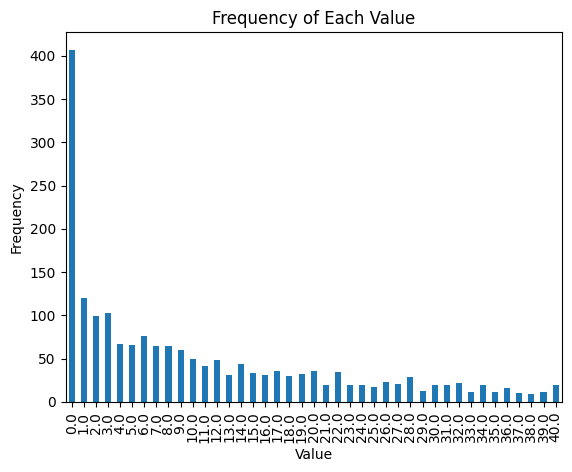

In [19]:
# Count frequencies of each unique value
counts = incidence['cases'].value_counts().sort_index().loc[0:40]  # sort_index keeps the natural order
# Plot
counts.plot(kind='bar')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of Each Value')
plt.show()

---
### Model Fitting

In [20]:
if 1:   
      # Define splines to be included in model: spline values (variable, lag, order, n. knots)
      ss = [['mean_temp_popw', 0, 3, 8],
            ['tot_prec_popw', 0, 2, 6]]
      template = '24'
      variant = 'a'
      model_name = template+variant
      stan_utils.write_model_code(template, ss, variant)
else:
      # Load Model
      model_name = '24'
model = cmdstanpy.CmdStanModel(stan_file=f'1-Models/m{model_name}.stan')

14:27:18 - cmdstanpy - INFO - compiling stan file /Users/lucaratzinger/Desktop/Files/13-Projects/p-dengue/1-Models/m24a.stan to exe file /Users/lucaratzinger/Desktop/Files/13-Projects/p-dengue/1-Models/m24a
14:27:22 - cmdstanpy - INFO - compiled model executable: /Users/lucaratzinger/Desktop/Files/13-Projects/p-dengue/1-Models/m24a


In [21]:
stan_data = stan_utils.input_data('23')
stan_data = stan_utils.input_data('24a', template='24', ss=ss)

modular


In [22]:
# Model Fit
fit = model.sample(data=stan_data, iter_sampling=2000, iter_warmup=2000, chains=2, show_console=False, seed=123)

14:27:23 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/4000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/4000 [00:00<?, ?it/s, (Warmup)]

14:28:54 - cmdstanpy - INFO - CmdStan done processing.


In [23]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-10520.600000,0.076162,3.051590,2.964460,-10526.100000,-10520.200000,-10516.100000,1667.41,2483.43,17.0370,1.003050
beta_0,-11.109600,0.013142,0.517025,0.531109,-11.959400,-11.105600,-10.252300,1564.72,2160.63,15.9877,1.000810
beta_urb,-0.884612,0.001385,0.085520,0.084960,-1.024410,-0.885809,-0.740713,3864.19,2587.34,39.4829,1.001650
alpha_2[1],-2.249040,0.011075,0.443051,0.445085,-2.968740,-2.258960,-1.505750,1607.02,2179.49,16.4199,1.000910
alpha_2[2],-1.489650,0.011418,0.429919,0.441793,-2.194820,-1.492190,-0.789261,1424.22,2278.90,14.5522,1.001040
alpha_2[3],-1.692760,0.011136,0.430908,0.443656,-2.405380,-1.695580,-0.993463,1512.93,2021.29,15.4586,1.001760
alpha_2[4],-2.503070,0.011468,0.458060,0.462864,-3.253050,-2.510130,-1.743520,1584.65,2277.72,16.1913,1.000640
alpha_2[5],-2.479390,0.012320,0.717139,0.707962,-3.695310,-2.466780,-1.315780,3437.96,2665.13,35.1278,1.000110
alpha_2[6],-0.173914,0.015837,0.994700,1.012000,-1.789950,-0.188050,1.445070,3972.78,2842.93,40.5925,1.000510
alpha_1[1],-1.243880,0.013044,0.882932,0.887633,-2.702340,-1.242680,0.202660,4614.66,3121.67,47.1509,1.001320


In [24]:
# read draws
draws = fit.draws_pd()
draws.to_csv(f'1-Models/m{model_name}_draws.csv')
draws = pd.read_csv(f'1-Models/m{model_name}_draws.csv')

---
### Visualising (Splines)

In [25]:
print(ss)

[['mean_temp_popw', 0, 3, 8], ['tot_prec_popw', 0, 2, 6]]


In [34]:
# spline (variable, lag, order, n. knots)
j = 2
s = ss[j-1]
order_, ni_input_, i_input_, ext_knots_ = stan_utils.i_split_spline_values_inputs(s)
input = np.linspace(np.min(ext_knots_), np.max(ext_knots_), 1000)
B = spline_values(input[:-1], s[2], ext_knots=ext_knots_)

alpha_draws = np.array(draws[[f'alpha_{j}[{i}]' for i in range(1, B.shape[1]+1)]])
curve_draws = np.einsum('ij,lj->il',alpha_draws, B)

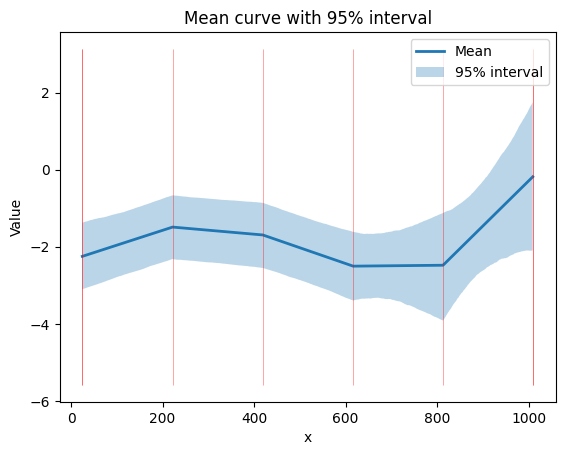

In [35]:
mean_curve = curve_draws.mean(axis=0)
l = np.percentile(curve_draws, 2.5, axis=0)
u = np.percentile(curve_draws, 97.5, axis=0)

# mean curve
plt.plot(input[:-1], mean_curve, label="Mean", linewidth=2)

plt.vlines(ext_knots_, ymin=np.min(curve_draws), ymax=np.max(curve_draws), alpha=0.5, lw=0.5, color='red')

# 95% band
plt.fill_between(input[:-1], l, u, alpha=0.3, label="95% interval")

plt.legend()
plt.xlabel("x")
plt.ylabel("Value")
plt.title("Mean curve with 95% interval")
plt.show()